Colocando somente as informações do look_back como input para a rede

# Importando bibliotecas

In [1]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from keras.models import Sequential
from keras.layers import Dense, LSTM

warnings.simplefilter("ignore")

from matplotlib.pyplot import figure
from matplotlib import style
plt.style.use('seaborn')

In [2]:
# Separação do dado de treino e teste da série temporal original
corte_teste = 500

foward_days = 100 # quantidade de dias a frente que queremos prever
look_back = 1*foward_days # quantidade de passos de tempo que estamos olhando para trás para realizar a previsão (Em função do foward_days)

n_iterations = 5 # Quantos blocos a frente queremos prever, utilizando sempre a última predição como input

thr = 0.10 # Definindo o threshold

media_movel_flag = False # False = sem media movel / True = com média movel
media_movel_dias = 10 # quantos dias de média móvel 

Colocamos o look_back igual ao foward_days para garantirmos que o input da previsão seguinte será diferente do input anterior.
Imagina que a Random Forest cria uma função abstrata que modela o problema físico que estamos tentando resolver. Esta função será contínua. Mais ainda, será Lipschitziana. Logo, se apendarmos apenas um valor ao vetor de tamanho look_back, a função tenderá a ser contínua no longo tempo.
Exemplo: função que dada uma sequencia retorna a média da sequencia.

# Importando o dataset

In [4]:
data = pd.read_excel('Volve_production_data.xlsx')

In [5]:
well_codes = list(data['WELL_BORE_CODE'].unique())

0 746


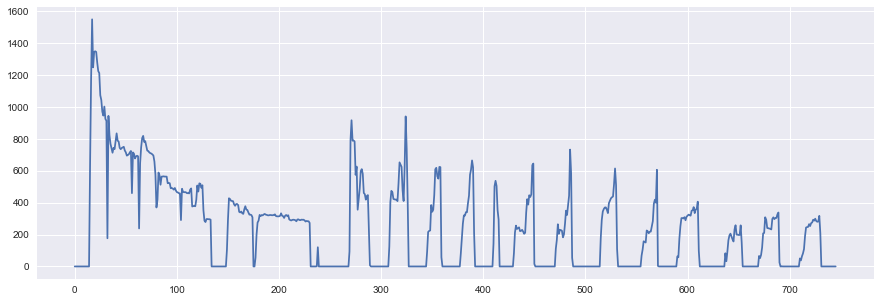

In [6]:
prod_data = data[data["WELL_BORE_CODE"]==well_codes[0]]
prod_data.sort_values(by='DATEPRD', ignore_index=True, inplace=True)
prod = prod_data['BORE_OIL_VOL']

print(prod.isna().sum(), prod.shape[0])

plt.figure(figsize=(15, 5))
prod.plot()
plt.show()

In [7]:
prod_array = prod.values

In [8]:
tam = prod_array.shape[0]

if media_movel_flag:
    media_movel_array = np.array([])
    
    for i in range(tam):
        
        if i > media_movel_dias:
            aux = np.mean(prod_array[i-media_movel_dias:i+media_movel_dias])
        else:
            for kk in range(media_movel_dias+1):
                aux = np.mean(prod_array[i-media_movel_dias+kk:i+media_movel_dias])
                if ~np.isnan(aux):
                    break
            
        media_movel_array = np.append(media_movel_array, aux)
else:
    media_movel_array = np.copy(prod_array)

In [9]:
print(prod_array.shape, media_movel_array.shape)

(746,) (746,)


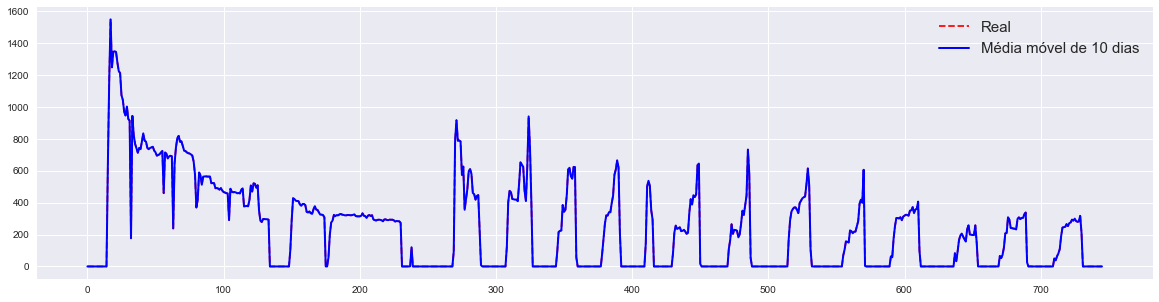

In [10]:
plt.figure(figsize=(20, 5))
plt.plot(prod_array, 'r--', label='Real')
plt.plot(media_movel_array, 'b', linewidth=2, label='Média móvel de '+str(media_movel_dias)+' dias')
plt.legend(fontsize=15)
plt.show()

In [11]:
cols = prod_data.columns.tolist()

In [12]:
for i, elem in enumerate(cols):
    print(str(i) + ':', elem)

0: DATEPRD
1: WELL_BORE_CODE
2: NPD_WELL_BORE_CODE
3: NPD_WELL_BORE_NAME
4: NPD_FIELD_CODE
5: NPD_FIELD_NAME
6: NPD_FACILITY_CODE
7: NPD_FACILITY_NAME
8: ON_STREAM_HRS
9: AVG_DOWNHOLE_PRESSURE
10: AVG_DOWNHOLE_TEMPERATURE
11: AVG_DP_TUBING
12: AVG_ANNULUS_PRESS
13: AVG_CHOKE_SIZE_P
14: AVG_CHOKE_UOM
15: AVG_WHP_P
16: AVG_WHT_P
17: DP_CHOKE_SIZE
18: BORE_OIL_VOL
19: BORE_GAS_VOL
20: BORE_WAT_VOL
21: BORE_WI_VOL
22: FLOW_KIND
23: WELL_TYPE


In [13]:
# cols_aux = [cols[9]] + [cols[10]] + [cols[15]] + [cols[16]] + cols[18:22]
cols_aux = ['AVG_DOWNHOLE_PRESSURE']# , 'AVG_DOWNHOLE_TEMPERATURE']

In [14]:
cols_aux

['AVG_DOWNHOLE_PRESSURE']

In [15]:
if prod_data[cols_aux].isna().sum().sum() > 0:
    prod_data.fillna(value=0.0, inplace=True)

In [16]:
prod1_production = media_movel_array.reshape(prod_array.shape[0], 1)
prod1_downhole_pressure = prod_data[cols_aux[0]].values.reshape(prod_array.shape[0], 1)
# prod1_downhole_temperatue = prod_data[cols_aux[1]].values.reshape(prod_array.shape[0], 1)
# prod1_whp_p = prod1[cols[15]].values.reshape(prod1.shape[0], 1)
# prod1_wht_p = prod1[cols[16]].values.reshape(prod1.shape[0], 1)

## Fazendo scaling das variaveis

In [17]:
scaler_production = MinMaxScaler()
scaler_downhole_pressure = MinMaxScaler()
# scaler_downhole_temperatue = MinMaxScaler()
# scaler_whp_p = MinMaxScaler()
# scaler_wht_p = MinMaxScaler()

In [18]:
prod1_production_scaled = scaler_production.fit_transform(prod1_production)
prod1_downhole_pressure_scaled = scaler_downhole_pressure.fit_transform(prod1_downhole_pressure)
# prod1_downhole_temperatue_scaled = scaler_downhole_temperatue.fit_transform(prod1_downhole_temperatue)
# prod1_whp_p_scaled = scaler_whp_p.fit_transform(prod1_whp_p)
# prod1_wht_p_scaled = scaler_wht_p.fit_transform(prod1_wht_p)

#### Verificando poço aberto / poço fechado

In [19]:
bool_poco = np.array([1 if a > 0 else 0 for a in prod1_production])

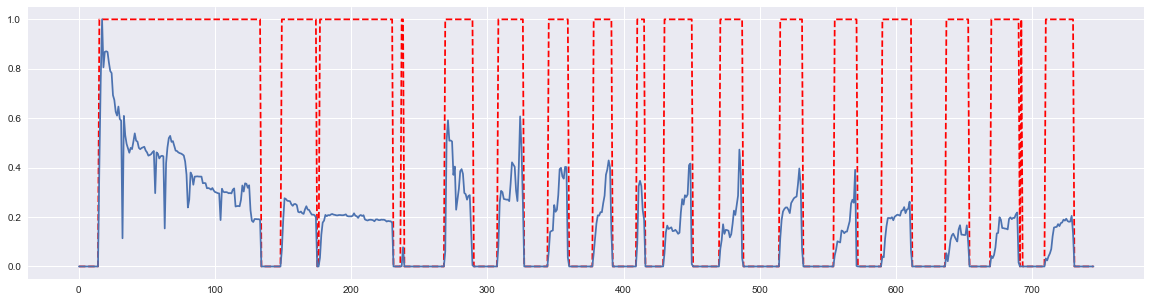

In [20]:
plt.figure(figsize=(20, 5))
plt.plot(bool_poco, '--r')
plt.plot(prod1_production_scaled)
plt.show()

### Juntando tudo num vetor só

In [21]:
# serie = np.hstack((prod1_production_scaled, prod1_downhole_pressure_scaled)) #, prod1_downhole_temperatue_scaled))
serie = np.hstack((prod1_production_scaled, bool_poco.reshape(-1, 1)))

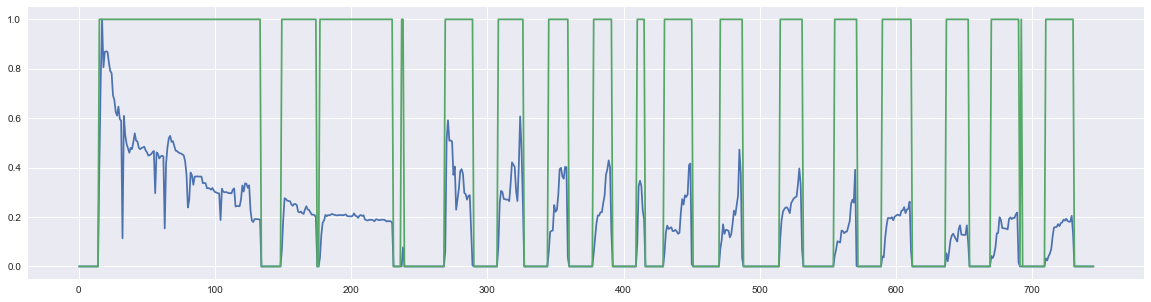

In [22]:
plt.figure(figsize=(20, 5))
plt.plot(serie)
plt.show()

In [23]:
def set_seq(seq, look_back, foward_days):
    '''Função para criar dataset de treino
       inputs:
           seq = Série temporal
           look_back = Número de índices que iremos avaliar para predizer o seguinte
           
       outputs:
           X = lista contendo todos os pedaços da série com tamanho look_back
           Y = lista contendo todos os itens seguintes às séries alocadas em X, de acordo com o índice'''
    
    X = []
    y = []
    
    # Andando por toda série temporal
    # Como precisamos de look_back índices para iniciar, precisamos retirar look_back do len(seq)
    for t in range(len(seq) - look_back - foward_days):
    
            # end se refere ao índice do último item do pedaço da série temporal de tamanho look_back
            end = t + look_back
            
            # Verificando se o ínidice do último item está além da série temporal
            if end + foward_days > (len(seq) - 1):
                break
            
            # Xseq é o pedaço da série temporal iniciando em t (loop for) e terminando em end (definido acima)
            Xseq = seq[t:end, :]
            
            
            
            #y_target é o item da série temporal imediatamente seguinte ao pedaço da série escolhido para Xseq
            y_target = seq[end:(end+foward_days), 0]
            
            # Appendando Xseq e y_target nas listas acima
            X.append(Xseq)
            y.append(y_target)
        
    return np.array(X), np.array(y) 

In [24]:
# Definindo as partes da série para treino e teste
serie_train = serie[:corte_teste]
serie_test = serie[corte_teste:]

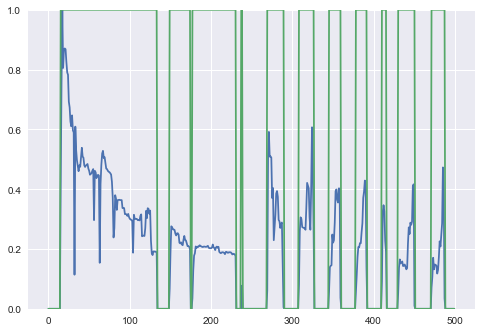

In [25]:
# Plotando as partes da serie para verificar se tá tudo bem
plt.plot(serie_train)
plt.ylim(0, 1)
plt.show()

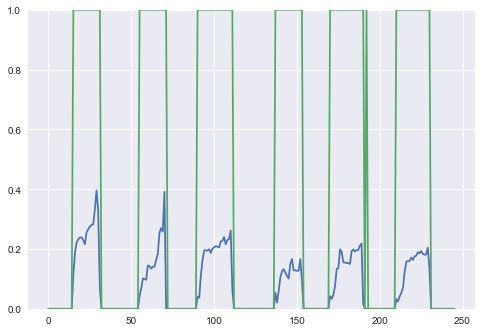

In [26]:
# Plotando as partes da serie para verificar se tá tudo bem
plt.plot(serie_test)
plt.ylim(0, 1)
plt.show()

In [27]:
# Separanto a serie de treino em pedaços para treinamento do modelo
Xaux, Yaux = set_seq(serie_train, look_back, foward_days)

In [28]:
# Verificando quantos pedaços conseguimos dividir nossa serie
print(Xaux.shape, Yaux.shape)

(300, 100, 2) (300, 100)


# LSTM

In [29]:
def power_element(base=2, power=0):
    a = 1
    for _ in range(power):
        a = a*base
    return a

In [30]:
for power in range(10):
    if power_element(2, power) > look_back:
        break

In [31]:
NUM_NEURONS_FirstLayer = power_element(2, power+2)
NUM_NEURONS_SecondLayer = power_element(2, power+1)
NUM_NEURONS_ThirdLayer = power_element(2, power)
EPOCHS = 500

print('NUM_NEURONS_FirstLayer:',NUM_NEURONS_FirstLayer,'\nNUM_NEURONS_SecondLayer:',NUM_NEURONS_SecondLayer,'\nNUM_NEURONS_ThirdLayer:',NUM_NEURONS_ThirdLayer,'\nEPOCHS:',EPOCHS)

NUM_NEURONS_FirstLayer: 512 
NUM_NEURONS_SecondLayer: 256 
NUM_NEURONS_ThirdLayer: 128 
EPOCHS: 500


In [32]:
modelLSTM = Sequential()
modelLSTM.add(LSTM(NUM_NEURONS_FirstLayer,input_shape=(look_back, 2), return_sequences=True, activation='tanh'))#, kernel_initializer='random_normal'))
modelLSTM.add(LSTM(NUM_NEURONS_SecondLayer,input_shape=(NUM_NEURONS_FirstLayer,1), activation='tanh'))#, kernel_initializer='random_normal'))
modelLSTM.add(Dense(NUM_NEURONS_ThirdLayer))#, activation='tanh', kernel_initializer='random_normal'))
modelLSTM.add(Dense(foward_days))#, activation='tanh', kernel_initializer='random_normal'))

modelLSTM.compile(loss='mean_squared_error', optimizer='adam')

2022-09-29 09:54:59.631426: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
history = modelLSTM.fit(Xaux, Yaux, epochs=EPOCHS, shuffle=True, batch_size=2, verbose=2)

Epoch 1/500
150/150 - 75s - loss: 0.0221 - 75s/epoch - 500ms/step
Epoch 2/500
150/150 - 71s - loss: 0.0200 - 71s/epoch - 472ms/step
Epoch 3/500
150/150 - 73s - loss: 0.0195 - 73s/epoch - 488ms/step
Epoch 4/500
150/150 - 62s - loss: 0.0195 - 62s/epoch - 413ms/step
Epoch 5/500
150/150 - 60s - loss: 0.0191 - 60s/epoch - 401ms/step
Epoch 6/500
150/150 - 74s - loss: 0.0193 - 74s/epoch - 492ms/step
Epoch 7/500
150/150 - 76s - loss: 0.0188 - 76s/epoch - 507ms/step
Epoch 8/500
150/150 - 75s - loss: 0.0189 - 75s/epoch - 498ms/step
Epoch 9/500
150/150 - 69s - loss: 0.0184 - 69s/epoch - 458ms/step
Epoch 10/500
150/150 - 64s - loss: 0.0182 - 64s/epoch - 430ms/step
Epoch 11/500
150/150 - 59s - loss: 0.0171 - 59s/epoch - 392ms/step
Epoch 12/500
150/150 - 58s - loss: 0.0142 - 58s/epoch - 387ms/step
Epoch 13/500
150/150 - 58s - loss: 0.0135 - 58s/epoch - 389ms/step
Epoch 14/500
150/150 - 58s - loss: 0.0120 - 58s/epoch - 386ms/step
Epoch 15/500
150/150 - 69s - loss: 0.0104 - 69s/epoch - 462ms/step
Epoc

Epoch 123/500
150/150 - 61s - loss: 8.4631e-04 - 61s/epoch - 404ms/step
Epoch 124/500
150/150 - 74s - loss: 0.0012 - 74s/epoch - 492ms/step
Epoch 125/500
150/150 - 55s - loss: 9.3964e-04 - 55s/epoch - 369ms/step
Epoch 126/500
150/150 - 55s - loss: 0.0012 - 55s/epoch - 370ms/step
Epoch 127/500
150/150 - 59s - loss: 0.0011 - 59s/epoch - 392ms/step
Epoch 128/500
150/150 - 57s - loss: 0.0011 - 57s/epoch - 381ms/step
Epoch 129/500
150/150 - 54s - loss: 8.2733e-04 - 54s/epoch - 363ms/step
Epoch 130/500
150/150 - 55s - loss: 0.0012 - 55s/epoch - 369ms/step
Epoch 131/500
150/150 - 66s - loss: 0.0010 - 66s/epoch - 439ms/step
Epoch 132/500
150/150 - 70s - loss: 9.7058e-04 - 70s/epoch - 466ms/step
Epoch 133/500
150/150 - 68s - loss: 9.9960e-04 - 68s/epoch - 454ms/step
Epoch 134/500
150/150 - 69s - loss: 7.9810e-04 - 69s/epoch - 462ms/step
Epoch 135/500
150/150 - 68s - loss: 6.6644e-04 - 68s/epoch - 454ms/step
Epoch 136/500
150/150 - 71s - loss: 6.1318e-04 - 71s/epoch - 476ms/step
Epoch 137/500
15

Epoch 238/500
150/150 - 72s - loss: 4.0470e-04 - 72s/epoch - 481ms/step
Epoch 239/500
150/150 - 73s - loss: 4.0307e-04 - 73s/epoch - 486ms/step
Epoch 240/500
150/150 - 73s - loss: 4.9906e-04 - 73s/epoch - 486ms/step
Epoch 241/500
150/150 - 73s - loss: 5.4580e-04 - 73s/epoch - 485ms/step
Epoch 242/500
150/150 - 54s - loss: 5.5869e-04 - 54s/epoch - 358ms/step
Epoch 243/500
150/150 - 72s - loss: 5.4350e-04 - 72s/epoch - 477ms/step
Epoch 244/500
150/150 - 73s - loss: 5.0262e-04 - 73s/epoch - 487ms/step
Epoch 245/500
150/150 - 73s - loss: 4.7682e-04 - 73s/epoch - 489ms/step
Epoch 246/500
150/150 - 75s - loss: 5.2121e-04 - 75s/epoch - 499ms/step
Epoch 247/500
150/150 - 76s - loss: 6.2225e-04 - 76s/epoch - 506ms/step
Epoch 248/500
150/150 - 67s - loss: 5.2853e-04 - 67s/epoch - 447ms/step
Epoch 249/500
150/150 - 67s - loss: 5.3898e-04 - 67s/epoch - 449ms/step
Epoch 250/500
150/150 - 69s - loss: 4.9510e-04 - 69s/epoch - 460ms/step
Epoch 251/500
150/150 - 72s - loss: 4.6521e-04 - 72s/epoch - 477

In [ ]:
plt.figure(figsize = (10, 5))
plt.plot(history.history['loss'], label='loss')
# plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.show()

# Verificando os dados de treino e teste

In [ ]:
# Separando a serie completa em pedaços para verificarmos como ficou o treinamento do modelo
X, y = set_seq(serie, look_back, foward_days)

In [ ]:
# Verificando quantos pedaços conseguimos dividir a série inteira
print(X.shape, y.shape)

In [ ]:
# # Fazendo o reshape, respeitando como input para o modelo RandomForest
# a, b, _ = X.shape
# X_ = X.reshape((a, b))

In [ ]:
# Fazendo predições com o X_
Xt = modelLSTM.predict(X)

In [ ]:
Xt.shape

In [ ]:
# Como queremos prever blocos de foward_days, retiramos todos que estão entre [forward_days, foward_days+i]
# Só queremos os múltiplos de foward_days
predLSTM = np.array([])
for i, a in enumerate(Xt):
    if np.mod(i, foward_days) == 0:
        predLSTM = np.append(predLSTM, a)

# predLSTM = np.array([a[0] for a in Xt])

In [ ]:
predLSTM.shape

In [ ]:
# Verificando onde parar e quantas partes iremos dividir o eixo X (usando o linspace do numpy)
stop = 0
split = 1

while stop < len(serie):
    stop += foward_days
    split += 1

In [ ]:
# Fazendo append com zeros para fitar a curva bonitinho no início
aux = 55
predLSTM_ = np.append(np.zeros(serie.shape[0]-predLSTM.shape[0]-foward_days+aux), predLSTM)

In [ ]:
# # Verificando o último bloco de predição que não é multiplo de foward_days
# a = serie.shape[0]-np.mod(serie.shape[0], foward_days)
# last_pred_X = serie[(a-look_back):a]
# last_pred_X = last_pred_X.reshape(1, look_back, serie.shape[-1])
# last_pred = modelLSTM.predict(last_pred_X)

In [ ]:
# # Appendando o que foi predito com o último bloco de predição
# predLSTM__ = np.append(predLSTM_, last_pred)

In [ ]:
a = 25
plt.figure(figsize=(a, a*0.27))
# ser1 = scaler.inverse_transform(serie)
plt.plot(prod1_production_scaled, 'r--', label='Target')
# ser2 = scaler.inverse_transform(predLSTM__.reshape(-1, 1))
plt.plot(bool_poco*0.5, 'g-', label='Poco aberto/fechado')
plt.plot(predLSTM_, 'b', label='Prediction')
plt.axvline(x=corte_teste, color='k', label='Corte treino/teste')
# plt.text(x=corte_teste-foward_days-90, y=0.7*prod1_production_scaled.max(), s='Treino', fontsize=a)
# plt.text(x=corte_teste-foward_days+50, y=0.7*prod1_production_scaled.max(), s='Teste', fontsize=a)
plt.legend(fontsize=16)
if foward_days > 9:
    plt.xticks(np.linspace(0, stop, split), fontsize=15, fontweight='bold', rotation=270)
plt.yticks(fontsize=15, fontweight='bold')
plt.title('Look_Back={} | Foward_Days={} | Epocas={} | Sem pressão futura | Média Móvel={}'.format(look_back, foward_days, EPOCHS, media_movel_flag), fontsize=20, fontweight='bold')
plt.ylim(-0.1, 1.1)
plt.show()

# Processando o resultado abaixo de um threshold

In [ ]:
thr = 0.1

In [ ]:
# Criando um array utilizando list_comprehension, transformando todos abaixo do thr em 0
lst = np.array([a if a > thr else 0 for a in predLSTM__]).reshape(-1, 1)

# lst = []
# for i in range(predRF__.shape[0]):
#     try:
#         if ser1[i] == 0:
#             lst.append(0)
#         else:
#             lst.append(predRF__[i])
            
#     except:
#         if predRF__[i] < thr:
#             lst.append(0)
#         else:
#             lst.append(predRF__[i])

# lst = np.array(lst)

In [ ]:
a = 22
plt.figure(figsize=(a, a*0.27))
# ser1 = scaler.inverse_transform(serie)
plt.plot(prod1_production_scaled, 'r--', label='Target')
# ser2 = scaler.inverse_transform(predLSTM__.reshape(-1, 1))
plt.plot(predLSTM__, 'g:',linewidth=3, label='True Prediction')
# ser3 = scaler.inverse_transform(lst.reshape(-1, 1))
plt.plot(lst, 'b', label='Processed Prediction')
plt.axvline(x=corte_teste, color='k', label='Corte treino/teste')
plt.text(x=corte_teste-90, y=0.7*prod1_production_scaled.max(), s='Treino', fontsize=a)
plt.text(x=corte_teste+50, y=0.7*prod1_production_scaled.max(), s='Teste', fontsize=a)
plt.legend(fontsize=16, loc='best')
if foward_days > 1:
    plt.xticks(np.linspace(0, stop, split), fontsize=15, fontweight='bold', rotation=270)
plt.yticks(fontsize=15, fontweight='bold')
plt.title('Look_Back={} | Foward_Days={}'.format(look_back, foward_days), fontsize=a, fontweight='bold')
# plt.xlim(0, 600)
plt.show()

# Colocando os outputs como inputs

In [ ]:
aux = predLSTM__[corte_teste:corte_teste+foward_days].reshape(look_back, 1) # Verificando o primeiro bloco de predição do modelo
pred = np.hstack((aux, serie[corte_teste:corte_teste+foward_days, 1:])).reshape(1, look_back, serie.shape[-1])
new_pred = np.array([]) # Vetor vazio para appendarmos as novas predições

n_iterations = 4

try:
    for i in range(n_iterations):
        yy = modelLSTM.predict(pred) # Realiza a predição seguinte cutilizando como parametros a predição anterior
        new_pred = np.append(new_pred, yy) # Appendando o resultado no vetor new_pred
        pred = np.hstack((yy.reshape(look_back, 1), serie[corte_teste:corte_teste+(i+1)*foward_days, 1:])).reshape(1, look_back, serie.shape[-1])
except:
    kk = 0

In [ ]:
pred_train = predLSTM__[:corte_teste] # Pegando a validação do modelo com a parte do treino
new_predLSTM__ = np.append(pred_train, new_pred) # Appendando a parte do treino com a nova predição, utilizando os outputs anteriores como inputs para novas predições

In [ ]:
a = serie.shape[0]-np.mod(serie.shape[0], foward_days)
last_pred = new_predLSTM__[(a-look_back):a].reshape(look_back, 1)
last_pred = np.hstack((last_pred, serie[(a-look_back):a, 1:])).reshape(1, look_back, serie.shape[-1])

In [ ]:
# Verificando onde parar e quantas partes iremos dividir o eixo X (usando o linspace do numpy)
stop = 0
split = 1

while stop < new_predLSTM__.shape[0]:
    stop += foward_days
    split += 1

In [ ]:
a = 22
plt.figure(figsize=(a, a*0.27))
# ser1 = scaler.inverse_transform(serie)
plt.plot(prod1_production_scaled, 'r--', label='Target')
# ser2 = scaler.inverse_transform(new_predLSTM__.reshape(-1, 1))
plt.plot(new_predLSTM__, 'b', label='Prediction')
plt.axvline(x=corte_teste, color='k', label='Corte treino/teste')
plt.text(x=corte_teste-foward_days-90, y=0.7*serie.max(), s='Treino', fontsize=a)
plt.text(x=corte_teste-foward_days+60, y=0.7*serie.max(), s='Teste', fontsize=a)
plt.legend(fontsize=16, loc='best')
if foward_days > 1:
    plt.xticks(np.linspace(0, stop, split), fontsize=15, fontweight='bold', rotation=270)
plt.yticks(fontsize=15, fontweight='bold')
plt.title('Look_Back={} | Foward_Days={}'.format(look_back, foward_days), fontsize=a, fontweight='bold')
# plt.xlim(0, 900)
plt.show()

# Tratando todos abaixo de um threshold

In [ ]:
# Criando um array utilizando list_comprehension, transformando todos abaixo do thr em 0
lst = np.array([a if a > thr else 0 for a in new_predLSTM__]).reshape(-1, 1)

# lst = []
# for i in range(new_predRF__.shape[0]):
#     try:
#         if ser1[i] == 0:
#             lst.append(0)
#         else:
#             lst.append(new_predRF__[i])
            
#     except:
#         if new_predRF__[i] < thr:
#             lst.append(0)
#         else:
#             lst.append(new_predRF__[i])

# lst = np.array(lst)

In [ ]:
a = 22
plt.figure(figsize=(a, a*0.27))
# ser1 = scaler.inverse_transform(serie)
plt.plot(prod1_production_scaled, 'r--', label='Target')
# ser2 = scaler.inverse_transform(new_predLSTM__.reshape(-1, 1))
plt.plot(new_predLSTM__, 'g:',linewidth=3, label='True Prediction')
# ser3 = scaler.inverse_transform(lst.reshape(-1, 1))
plt.plot(lst, 'b', label='Processed Prediction')
plt.axvline(x=corte_teste, color='k', label='Corte treino/teste')
plt.text(x=corte_teste-foward_days-90, y=0.7*prod1_production_scaled.max(), s='Treino', fontsize=a)
plt.text(x=corte_teste-foward_days+50, y=0.7*prod1_production_scaled.max(), s='Teste', fontsize=a)
plt.legend(fontsize=16, loc='best')
if foward_days > 1:
    plt.xticks(np.linspace(0, stop, split), fontsize=15, fontweight='bold', rotation=270)
plt.yticks(fontsize=15, fontweight='bold')
plt.title('Look_Back={} | Foward_Days={}'.format(look_back, foward_days), fontsize=a, fontweight='bold')
# plt.xlim(0, 900)
plt.show()

In [ ]:
a = 22
plt.figure(figsize=(a, a*0.27))
# ser1 = scaler.inverse_transform(serie)
plt.plot(prod1_production_scaled, 'r--', label='Target')
# ser2 = scaler.inverse_transform(predLSTM__.reshape(-1, 1))
plt.plot(predLSTM__, 'b', label='Prediction 1')

plt.plot(new_predLSTM__, 'g-.', label='Prediction 2')

plt.axvline(x=corte_teste, color='k', label='Corte treino/teste')
plt.text(x=corte_teste-foward_days-90, y=0.7*prod1_production_scaled.max(), s='Treino', fontsize=a)
plt.text(x=corte_teste-foward_days+50, y=0.7*prod1_production_scaled.max(), s='Teste', fontsize=a)
plt.legend(fontsize=16, loc='best')
if foward_days > 1:
    plt.xticks(np.linspace(0, stop, split), fontsize=15, fontweight='bold', rotation=270)
plt.yticks(fontsize=15, fontweight='bold')
plt.title('Look_Back={} | Foward_Days={}'.format(look_back, foward_days), fontsize=a, fontweight='bold')
# plt.xlim(0, 600)
plt.show()